<a href="https://colab.research.google.com/github/chris051091/Seminario-3/blob/master/anomalias/src/Anomalias_vizcaina_20h_7h.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install windrose

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from datetime import timedelta
import matplotlib.cm as cm
from functools import reduce
from math import cos, sin, atan, pi
from windrose import WindroseAxes
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
PATH_DRIVE = 'drive/MyDrive/Seminario-3-master'
PATH_DADOS = '/preprocess/dados/'
PATH_DADOS_EVENTOS = '/dados/'
PATH_ANOMALIAS = '/anomalias/'
NOMBRE_ESTACION = 'vizcaina'
FILE_DATOS_ESTACION = 'eventos_vizcaina_2.csv'

LISTA_VAR = ['temp', 'hum', 'pres']
LISTA_PWV = []
LISTA_VAR_10M = ['viento']
LISTA_PREC = ['prec']

PATH_FINAL_DADOS_TRATADOS = PATH_DRIVE + PATH_DADOS + NOMBRE_ESTACION + '/tratados/'
FILES_TRATADOS = [NOMBRE_ESTACION.lower() + f'_tratados_{VAR.lower()}.csv' for VAR in LISTA_VAR]
FILES_PWV = [NOMBRE_ESTACION.lower() + f'_tratados_{VAR.lower()}.csv' for VAR in LISTA_PWV]
FILES_TRATADOS_10M = [NOMBRE_ESTACION.lower() + f'_tratados_{VAR.lower()}.csv' for VAR in LISTA_VAR_10M]
FILES_TRATADOS_PREC = [NOMBRE_ESTACION.lower() + f'_tratados_{VAR.lower()}.csv' for VAR in LISTA_PREC]

Cargando datos de Temp, Hum, Pres

In [4]:
dfList = []
for f in FILES_TRATADOS:
  df = pd.read_csv(PATH_FINAL_DADOS_TRATADOS + f,
                  sep = ';', 
                )
  dfList.append(df)

In [5]:
df = reduce(lambda df1,df2: pd.merge(df1,df2,on='FECHA', how='outer'), dfList)
df = df.sort_values(by=['FECHA']).reset_index(drop = True)
df['HORA'] = df['FECHA'].apply(lambda x: x[11:13])

Cargando datos de Vapor de Agua

In [6]:
dfList = []
PWV_columns = []
if FILES_PWV:
    
  for f in FILES_PWV:
    dfp = pd.read_csv(PATH_FINAL_DADOS_TRATADOS + f,
                    sep = ';', 
                  )
    dfList.append(dfp)
    PWV_columns += [col for col in dfp if col != 'FECHA']


  dfPWV = reduce(lambda df1,df2: pd.merge(df1,df2,on='FECHA', how='outer'), dfList)
  dfPWV = dfPWV.sort_values(by=['FECHA']).reset_index(drop = True)

  dfPWV['FECHA_HORA'] = dfPWV['FECHA'].apply(lambda x: x[0:13])
  dfPWV = dfPWV.groupby('FECHA_HORA').agg('mean').reset_index()

  for var in PWV_columns:
    dfPWV = dfPWV.loc[~dfPWV[var].isnull()].reset_index(drop = True)

  dfPWV['FECHA'] = pd.to_datetime(dfPWV['FECHA_HORA'], format='%Y-%m-%d %H').dt.tz_localize('America/Bogota').astype(str)
else:
  dfPWV = pd.DataFrame(columns = ['FECHA', 'PWV'])

In [7]:
dfPWV

,FECHA,PWV


## Cargando datos de Vientos

$ \theta_p  = arctan(U_p / V_p) $ Direccíon del viento promedio

In [8]:
dfList = []
for f in FILES_TRATADOS_10M:
  dfaux = pd.read_csv(PATH_FINAL_DADOS_TRATADOS + f,
                  sep = ';', 
                )
  dfList.append(dfaux)

In [9]:
df10m = reduce(lambda df1,df2: pd.merge(df1,df2,on='FECHA', how='outer'), dfList)

df10m['FECHA_HORA'] = df10m['FECHA'].apply(lambda x: x[0:13])
df10m['X_VIENTO'] = df10m['VELVIENTO'] * np.sin(np.deg2rad(df10m['DIRECVIENTO'] - 180))
df10m['Y_VIENTO'] = df10m['VELVIENTO'] * np.cos(np.deg2rad(df10m['DIRECVIENTO'] - 180))

dfViento = df10m.copy()

df10m = df10m.groupby('FECHA_HORA').agg({'X_VIENTO' : 'mean', 'Y_VIENTO' : 'mean' }).reset_index()
df10m['HORA'] = df10m['FECHA_HORA'].apply(lambda x: x[11:13])
df10m['FECHA'] = pd.to_datetime(df10m['FECHA_HORA'], format='%Y-%m-%d %H').dt.tz_localize('America/Bogota').astype(str)

## Cargando datos de precipitación

In [10]:
dfList = []
PREC_columns = []
if FILES_TRATADOS_PREC:
    
  for f in FILES_TRATADOS_PREC:
    dfp = pd.read_csv(PATH_FINAL_DADOS_TRATADOS + f,
                    sep = ';', 
                  )
    dfList.append(dfp)
    PREC_columns += [col for col in dfp if col != 'FECHA']


  dfPrec = reduce(lambda df1,df2: pd.merge(df1,df2,on='FECHA', how='outer'), dfList)
  dfPrec = dfPrec.sort_values(by=['FECHA']).reset_index(drop = True)

  # dfPWV['FECHA_HORA'] = dfPWV['FECHA'].apply(lambda x: x[0:13])
  # dfPWV = dfPWV.groupby('FECHA_HORA').agg('mean').reset_index()

  for var in PREC_columns:
    dfPrec = dfPrec.loc[~dfPrec[var].isnull()].reset_index(drop = True)

  # dfPWV['FECHA'] = pd.to_datetime(dfPWV['FECHA_HORA'], format='%Y-%m-%d %H').dt.tz_localize('America/Bogota').astype(str)
else:
  dfPrec = pd.DataFrame(columns = ['FECHA'])



In [11]:
dfPrec

,FECHA,PREC
0,2011-01-01 00:10:00-05:00,0.0
1,2011-01-01 00:20:00-05:00,0.0
2,2011-01-01 00:30:00-05:00,0.0
3,2011-01-01 00:40:00-05:00,0.0
4,2011-01-01 00:50:00-05:00,0.0
...,...,...
307957,2017-12-31 23:10:00-05:00,0.0
307958,2017-12-31 23:20:00-05:00,0.0
307959,2017-12-31 23:30:00-05:00,0.0
307960,2017-12-31 23:40:00-05:00,0.0


## Cruzamiento de datos de Temp, hum y pres con PWV

In [12]:
dfDatos = pd.merge(df[['FECHA', 'TEMP', 'HUM', 'PRESION']], dfPWV[['FECHA', 'PWV']], on = 'FECHA', how = 'outer')
dfDatos['HORA'] = dfDatos['FECHA'].apply(lambda x: x[11:13])

dfmean = dfDatos.groupby('HORA').agg('mean').reset_index(level=0)

columns_mean = [col for col in dfmean.columns if col != 'HORA']
for col in columns_mean:
  dfmean = dfmean.rename(columns={col : f'{col}_mean'})

dfmean

,HORA,TEMP_mean,HUM_mean,PRESION_mean
0,00,24.940379,97.182825,1002.528390
1,01,24.658066,97.686138,1002.229700
2,02,24.389596,98.116690,1002.077061
3,03,24.145021,98.494845,1002.064574
4,04,23.934742,98.794035,1002.341801
5,05,23.738659,98.998600,1002.881911
6,06,23.622704,99.182158,1003.515191
7,07,24.827433,97.525376,1004.405851
8,08,26.731766,88.216884,1004.908196
9,09,29.174911,79.913592,1003.285490


## Cargando Df de los eventos

In [13]:
dfEventos = pd.read_csv(PATH_DRIVE + PATH_DADOS_EVENTOS + FILE_DATOS_ESTACION, 
                 sep = ';'
                )
dfEventos = dfEventos.sort_values(by='date_min_t').reset_index(drop = True)
dfEventos['FECHA'] = pd.to_datetime(dfEventos['date_min_t'], format='%Y %m %d %H %M').dt.tz_localize('America/Bogota')
dfEventos['FECHA_MIN'] = dfEventos['FECHA'].dt.round('10min')  
dfEventos['FECHA'] = dfEventos['FECHA'].dt.round('H')
dfEventos = dfEventos[['FECHA', 'FECHA_MIN', 'min_t', 'lon_t', 'lat_t']]
dfEventos

,FECHA,FECHA_MIN,min_t,lon_t,lat_t
0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058
1,2011-02-19 04:00:00-05:00,2011-02-19 04:20:00-05:00,224.5,-73.550,6.915
2,2011-03-06 03:00:00-05:00,2011-03-06 03:20:00-05:00,219.7,-73.836,6.915
3,2011-03-09 01:00:00-05:00,2011-03-09 01:20:00-05:00,216.9,-73.693,6.915
4,2011-04-23 20:00:00-05:00,2011-04-23 20:20:00-05:00,196.2,-73.693,6.915
...,...,...,...,...,...
83,2017-11-08 21:00:00-05:00,2017-11-08 21:20:00-05:00,199.1,-73.693,6.915
84,2017-11-10 00:00:00-05:00,2017-11-10 00:20:00-05:00,208.2,-73.836,7.058
85,2017-11-20 02:00:00-05:00,2017-11-20 01:40:00-05:00,214.6,-73.836,7.058
86,2017-11-23 05:00:00-05:00,2017-11-23 04:40:00-05:00,219.8,-73.550,7.058


# Cargando Eventos e encontrando intervalo n horas antes y después

In [14]:
funtime = lambda x, hour : [x + timedelta(hours = h) for h in (range(0, hour+1) if hour > 0 else range(hour, 0))]

# [base - datetime.timedelta(days=x) for x in range(numdays)]
dfEventAn = dfEventos.copy()
# pd.set_option('display.max_colwidth', None)

# ==================================
int_horas = 8
int_minutes = int_horas * 6 * 10
# ==================================
dfEventAn['FECHA_ANTES'] = dfEventAn['FECHA'].apply(funtime, hour = -int_horas)
dfEventAn['FECHA_DESPUES'] = dfEventAn['FECHA'].apply(funtime, hour = int_horas)
dfEventAn['FECHA_INTERVALO'] = dfEventAn['FECHA_ANTES'] + dfEventAn['FECHA_DESPUES']
dfEventAn = dfEventAn.drop(columns=['FECHA_ANTES', 'FECHA_DESPUES']).explode('FECHA_INTERVALO')
dfEventAn['FECHA_POS'] = (dfEventAn['FECHA_INTERVALO'] - dfEventAn['FECHA'])/ pd.Timedelta(hours=1)
dfEventAn = dfEventAn.rename(columns={'FECHA' : 'FECHA_EVENTO', 'FECHA_INTERVALO': 'FECHA'}).reset_index()
dfEventAn['FECHA'] = dfEventAn['FECHA'].astype(str)


dfEventAn.head(15)

,index,FECHA_EVENTO,FECHA_MIN,min_t,lon_t,lat_t,FECHA,FECHA_POS
0,0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 21:00:00-05:00,-8.0
1,0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 22:00:00-05:00,-7.0
2,0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 23:00:00-05:00,-6.0
3,0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-13 00:00:00-05:00,-5.0
4,0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-13 01:00:00-05:00,-4.0
5,0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-13 02:00:00-05:00,-3.0
6,0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-13 03:00:00-05:00,-2.0
7,0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-13 04:00:00-05:00,-1.0
8,0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-13 05:00:00-05:00,0.0
9,0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-13 06:00:00-05:00,1.0


# Cruzamiento con las variables metereológicas. En terminos de 1h


In [15]:
dfCross = pd.merge(dfEventAn, dfDatos, on='FECHA', how = 'left')
dfCross['HORA'] = dfCross['FECHA'].apply(lambda x: x[11:13])
dfCross = pd.merge(dfCross, dfmean, on = 'HORA', how='left')

list_anomalias = []
for col in columns_mean:
  anomalia = f'{col}_anomalia'
  list_anomalias.append(anomalia)
  dfCross[anomalia] = dfCross[f'{col}'] - dfCross[f'{col}_mean'] 

dfAnomalia = dfCross[list_anomalias + ['FECHA_POS']].groupby('FECHA_POS').agg(['mean', 'std']).reset_index()

In [16]:
dfAnomalia

FECHA_POS TEMP_anomalia           HUM_anomalia           PRESION_anomalia  \
                      mean       std         mean       std             mean   
0       -8.0      0.313457  1.272381     0.303677  5.613169        -1.177072   
1       -7.0      0.371287  1.254279    -0.211820  5.347254        -1.159257   
2       -6.0      0.463053  1.339063     0.387660  4.981235        -0.990284   
3       -5.0      0.536771  1.266859    -0.507361  5.875427        -1.147055   
4       -4.0      0.438952  1.051251    -0.090501  5.290306        -1.344571   
5       -3.0      0.575776  0.960205    -0.216755  4.597962        -1.681351   
6       -2.0      0.642582  0.960855    -0.735208  4.756098        -1.275400   
7       -1.0      0.544045  1.024049    -0.478233  3.851968        -1.552902   
8        0.0      0.194884  1.154049    -0.220133  2.631388        -1.459903   
9        1.0     -0.409998  1.190129     0.218715  2.775148        -1.328218   
10       2.0     -0.641412  1.260162     1.356291  4.107171        -0.922033   
11       3.0     -0.724524  1.587410     2.709925  5.941120        -0.582647   
12       4.0     -0.870439  1.840225     3.326923  7.500779        -0.279395   
13       5.0     -0.773072  1.828540     3.962711  7.846009        -0.342808   
14       6.0     -1.007673  1.906563     4.394994  9.036786         0.047439   
15       7.0     -0.902592  1.727372     4.248794  7.132514         0.121061   
16       8.0     -1.190189  1.907442     5.669236  7.460127        -0.051943   

              
         std  
0   1.620191  
1   1.994167  
2   2.654993  
3   2.767963  
4   2.450845  
5   2.172406  
6   3.233782  
7   2.513037  
8   2.503455  
9   2.986905  
10  3.413159  
11  3.606953  
12  3.462804  
13  3.216444  
14  2.844008  
15  2.859367  
16  2.630327

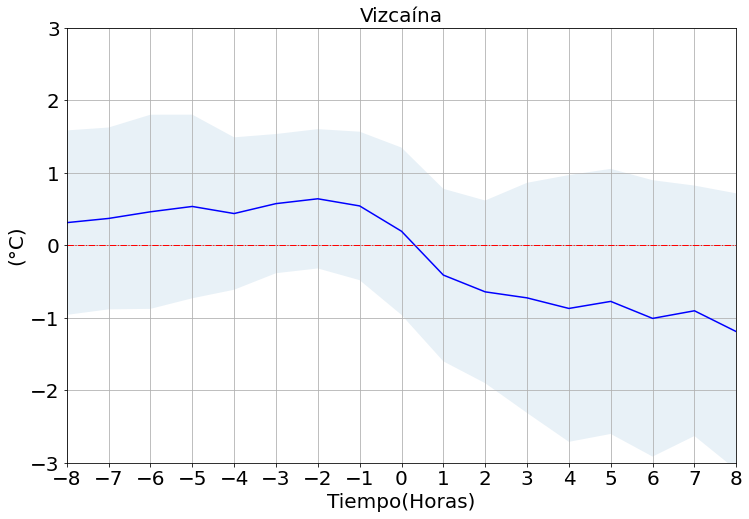

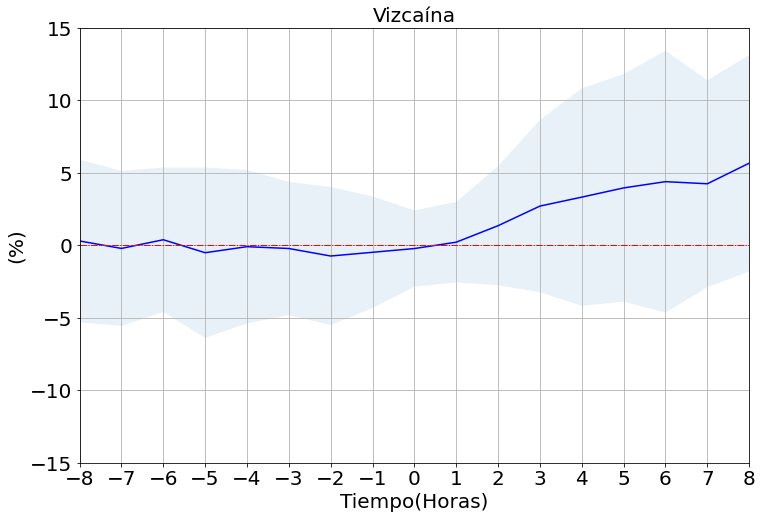

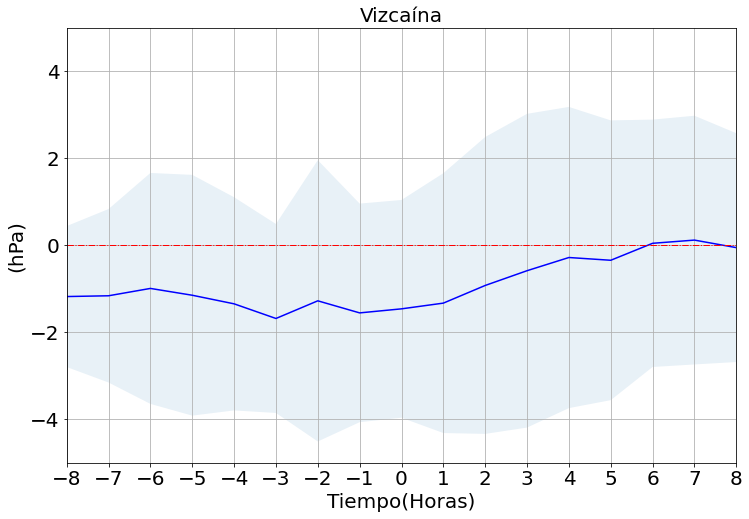

In [17]:
def plot_anomalias(df, anomalia, titulo, name_to_save, ylabel_name, int_horas, ylimit = []):
  plt.figure(figsize = (12,8))

  df['FECHA_POS'] = df['FECHA_POS'].astype(int)
  df['CERO'] = 0
  plt.xticks(df['FECHA_POS'], fontsize= 20)
  plt.yticks(fontsize= 20)
  plt.plot(df['FECHA_POS'], df[(anomalia, 'mean')], color = 'b')
  plt.fill_between(df['FECHA_POS'], df[(anomalia, 'mean')] + df[(anomalia, 'std')], df[(anomalia, 'mean')] - df[(anomalia, 'std')], alpha=.1, linestyle = '--', linewidth = 0.5)
  plt.plot(df['FECHA_POS'], df['CERO'], color = 'r', linestyle = '-.', linewidth = 1)
  plt.grid()
  plt.xlim([-int_horas, int_horas])
  
  if ylimit:
    plt.ylim(*ylimit)
  else:
    plt.ylim(-20,20)

  plt.xlabel("Tiempo(Horas)", fontsize= 20)
  plt.ylabel(ylabel_name, fontsize= 20)
  plt.title("Vizcaína", fontsize= 20)

  plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + name_to_save, format='png', bbox_inches = 'tight' )

dict_names = {'TEMP_anomalia' : {'title' : 'Anomalias de Temperatura', 'name2save' : f'anomalias_temperatura_20h_7h_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : '(°C)', 'ylimit': [-3, 3]},
              'HUM_anomalia' : {'title' : 'Anomalias de Humedad', 'name2save' : f'anomalias_humedad_20h_7h_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : '(%)', 'ylimit': [-15, 15]},
              'PRESION_anomalia' : {'title' : 'Anomalias de Presion', 'name2save' : f'anomalias_presion_20h_7h_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : '(hPa)', 'ylimit': [-5, 5]},
              # 'PWV_anomalia' : {'title' : 'Anomalias de Vapor de agua', 'name2save' : f'anomalias_pwv_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : 'Vapor de agua (mm)'}
    }

for key in dict_names:
  plot_anomalias(dfAnomalia, key, dict_names[key]['title'], dict_names[key]['name2save'], dict_names[key]['ylabel'], int_horas, dict_names[key]['ylimit'])

# dfAnomalia

# Análisis con los 21 Eventos que tienen todas las variábles metereológicas completas

In [18]:
dfEventos0 = dfCross.loc[dfCross['FECHA_POS'] == 0.]
dfEventos0 = dfEventos0[['FECHA_EVENTO', 'min_t', 'index'] + columns_mean]
dfEventos0['NUMERO_VARS'] = dfEventos0[columns_mean].notnull().sum(axis=1)
dfEventos0

,FECHA_EVENTO,min_t,index,TEMP,HUM,PRESION,NUMERO_VARS
8,2011-02-13 05:00:00-05:00,204.5,0,24.2,96.0,NaN,2
25,2011-02-19 04:00:00-05:00,224.5,1,23.6,95.0,NaN,2
42,2011-03-06 03:00:00-05:00,219.7,2,24.0,94.0,NaN,2
59,2011-03-09 01:00:00-05:00,216.9,3,24.9,99.0,NaN,2
76,2011-04-23 20:00:00-05:00,196.2,4,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...
1419,2017-11-08 21:00:00-05:00,199.1,83,24.9,96.0,997.0,3
1436,2017-11-10 00:00:00-05:00,208.2,84,24.6,100.0,998.2,3
1453,2017-11-20 02:00:00-05:00,214.6,85,23.3,100.0,998.5,3
1470,2017-11-23 05:00:00-05:00,219.8,86,24.4,100.0,998.7,3


In [19]:
dfEventos0.count()

FECHA_EVENTO    88
min_t           88
index           88
TEMP            70
HUM             70
PRESION         50
NUMERO_VARS     88
dtype: int64

In [20]:
dfEventos0['NUMERO_VARS'].value_counts()

3    50
2    20
0    18
Name: NUMERO_VARS, dtype: int64

In [21]:
dfVarsCompletas = dfEventos0.loc[dfEventos0['NUMERO_VARS'] == 3]
indexVarsCompletas = dfVarsCompletas['index']
dfVarsComp = pd.merge(dfCross, indexVarsCompletas, on = 'index', how = 'inner')

dfAnomaliaVarsComp = dfVarsComp[list_anomalias + ['FECHA_POS']].groupby('FECHA_POS').agg(['mean', 'std']).reset_index()
dfAnomaliaVarsComp

FECHA_POS TEMP_anomalia           HUM_anomalia           PRESION_anomalia  \
                      mean       std         mean       std             mean   
0       -8.0      0.371700  1.318590     0.890318  5.393285        -1.249357   
1       -7.0      0.468028  1.267444     0.236886  5.285673        -1.317738   
2       -6.0      0.478058  1.363476     0.867315  5.021865        -1.277653   
3       -5.0      0.626818  1.274284     0.069920  5.497269        -1.506134   
4       -4.0      0.562167  1.108866     0.257724  5.696828        -1.344571   
5       -3.0      0.689131  0.977831     0.175424  4.845213        -1.681351   
6       -2.0      0.826771  0.914820    -0.566590  5.056460        -1.546222   
7       -1.0      0.671803  1.030393    -0.248466  4.147141        -1.552902   
8        0.0      0.294834  1.043338    -0.115794  2.619120        -1.459903   
9        1.0     -0.301197  1.174366     0.385319  2.957251        -1.328218   
10       2.0     -0.496857  1.241551     1.572018  4.472809        -1.196494   
11       3.0     -0.453949  1.451951     2.438652  5.745822        -0.878248   
12       4.0     -0.529041  1.685865     2.305091  6.829482        -0.618349   
13       5.0     -0.645701  1.926267     3.595281  7.962987        -0.604053   
14       6.0     -0.835142  1.980632     4.530149  9.868203         0.047439   
15       7.0     -0.728602  1.837222     4.255782  7.713575         0.147725   
16       8.0     -1.005853  1.878227     5.783799  7.208589        -0.043333   

              
         std  
0   1.561685  
1   1.674644  
2   1.751114  
3   1.927830  
4   2.450845  
5   2.172406  
6   2.632786  
7   2.513037  
8   2.503455  
9   2.986905  
10  3.021328  
11  3.173267  
12  2.959941  
13  2.660358  
14  2.844008  
15  2.882711  
16  2.656873

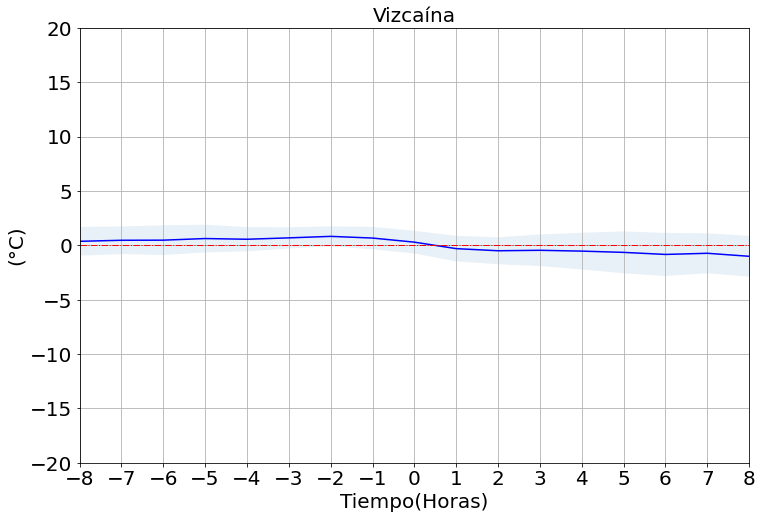

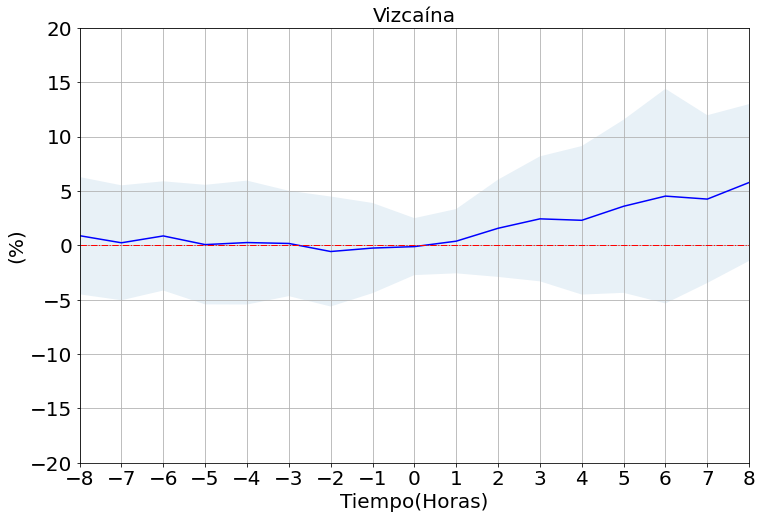

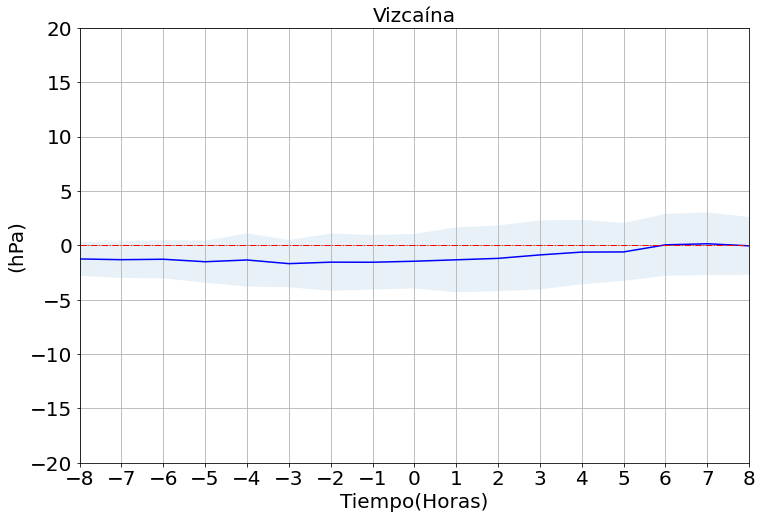

In [22]:
dict_names = {'TEMP_anomalia' : {'title' : 'Anomalias de Temperatura', 'name2save' : f'anomalias_temperatura_vars_comp_20h_7h_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : '(°C)'},
              'HUM_anomalia' : {'title' : 'Anomalias de Humedad', 'name2save' : f'anomalias_humedad_vars_comp_20h_7h_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : '(%)'},
              'PRESION_anomalia' : {'title' : 'Anomalias de Presion', 'name2save' : f'anomalias_presion_vars_comp_20h_7h_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : '(hPa)'},
              # 'PWV_anomalia' : {'title' : 'Anomalias de Vapor de agua', 'name2save' : f'anomalias_pwv_vars_comp_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : 'Vapor de agua (mm)'}
    }

for key in dict_names:
  plot_anomalias(dfAnomaliaVarsComp, key, dict_names[key]['title'], dict_names[key]['name2save'], dict_names[key]['ylabel'], int_horas)

# Cargando Eventos e encontrando intervalo m minutos antes y después

In [23]:
funtimeMinutes = lambda x, minute : [x + timedelta(minutes = h) for h in (range(0, minute+1, 10) if minute > 0 else range(minute, 0, 10))]

dfEventAnMin = dfEventos.copy()

dfEventAnMin['FECHA_ANTES_MIN'] = dfEventAnMin['FECHA_MIN'].apply(funtimeMinutes, minute = -int_minutes)
dfEventAnMin['FECHA_DESPUES_MIN'] = dfEventAnMin['FECHA_MIN'].apply(funtimeMinutes, minute = int_minutes)

dfEventAnMin['FECHA_INTERVALO'] = dfEventAnMin['FECHA_ANTES_MIN'] + dfEventAnMin['FECHA_DESPUES_MIN']
dfEventAnMin = dfEventAnMin.drop(columns=['FECHA_ANTES_MIN', 'FECHA_DESPUES_MIN']).explode('FECHA_INTERVALO')
dfEventAnMin['FECHA_POS'] = (dfEventAnMin['FECHA_INTERVALO'] - dfEventAnMin['FECHA_MIN'])/ pd.Timedelta(minutes=1)
dfEventAnMin = dfEventAnMin.rename(columns={'FECHA_MIN' : 'FECHA_EVENTO', 'FECHA': 'FECHA_HORA', 'FECHA_INTERVALO': 'FECHA'}).reset_index(drop=True)
dfEventAnMin['FECHA'] = dfEventAnMin['FECHA'].astype(str)

dfEventAnMin.head(10)

,FECHA_HORA,FECHA_EVENTO,min_t,lon_t,lat_t,FECHA,FECHA_POS
0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 21:20:00-05:00,-480.0
1,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 21:30:00-05:00,-470.0
2,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 21:40:00-05:00,-460.0
3,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 21:50:00-05:00,-450.0
4,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 22:00:00-05:00,-440.0
5,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 22:10:00-05:00,-430.0
6,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 22:20:00-05:00,-420.0
7,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 22:30:00-05:00,-410.0
8,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 22:40:00-05:00,-400.0
9,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 22:50:00-05:00,-390.0


In [24]:
dfCrossPrec = pd.merge(dfEventAnMin, dfPrec, on='FECHA', how = 'left')

dfCrossPrecGroup = dfCrossPrec.groupby("FECHA_POS").agg({"PREC" : ["mean", "std"]})
dfCrossPrecGroup = dfCrossPrecGroup.rename(columns = {("PREC", "mean") : "PREC_mean", ("PREC", "std") : "PREC_std"}).reset_index()

dfCrossPrecGroup

FECHA_POS      PREC          
                  mean       std
0     -480.0  0.000000  0.000000
1     -470.0  0.000000  0.000000
2     -460.0  0.001587  0.012599
3     -450.0  0.000000  0.000000
4     -440.0  0.001538  0.012403
..       ...       ...       ...
92     440.0  0.085075  0.447300
93     450.0  0.073134  0.360379
94     460.0  0.131818  0.657070
95     470.0  0.198507  0.978170
96     480.0  0.168657  0.755427

[97 rows x 3 columns]

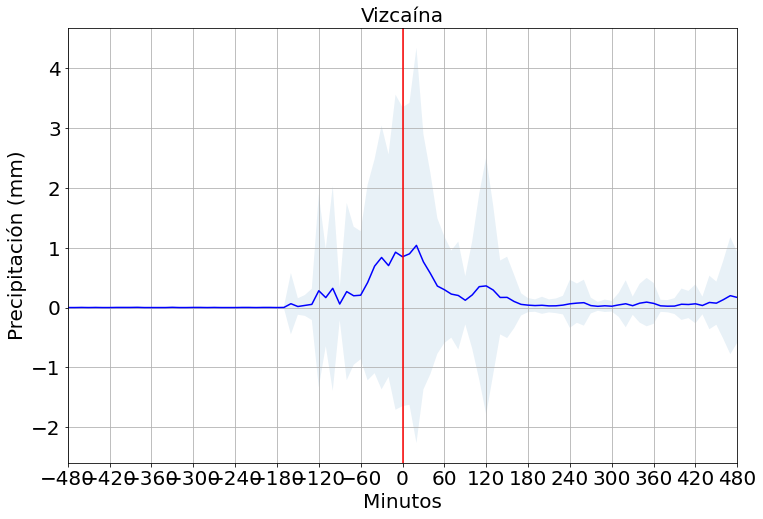

In [25]:
def plot_10m_interval(df, campo, titulo, name_to_save, ylabel_name, int_minutes, ylimit = [], has_std = True):
  plt.figure(figsize = (12,8))

  df['FECHA_POS'] = df['FECHA_POS'].astype(int)
  df['CERO'] = 0
  frequency = 6
  plt.xticks(df['FECHA_POS'][::frequency], fontsize= 20)
  plt.yticks(fontsize= 20)
  if has_std:
    plt.plot(df['FECHA_POS'], df[(campo, 'mean')], color = 'b')
    plt.fill_between(df['FECHA_POS'], df[(campo, 'mean')] + df[(campo, 'std')], df[(campo, 'mean')] - df[(campo, 'std')], alpha=.1, linestyle = '--', linewidth = 0.5)
  else:
    plt.plot(df['FECHA_POS'], df[campo], color = 'b')
  # plt.plot(df['FECHA_POS'], df['CERO'], color = 'r', linestyle = '-.', linewidth = 1)
  plt.grid()
  plt.axvline(color = 'r')
  plt.xlim([-int_minutes, int_minutes])
  if ylimit:
    plt.ylim(*ylimit)
  plt.xlabel("Minutos", fontsize= 20)
  plt.ylabel(ylabel_name, fontsize= 20)
  plt.title("Vizcaína", fontsize= 20)

  plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + name_to_save, format='png', bbox_inches = 'tight' )

dict_names = {'PREC' : {'title' : 'Análisis de Precipitación de eventos convectivos', 'name2save' : f'analisis_prec_20h_7h_{NOMBRE_ESTACION}_{int_minutes}m.png', 'ylabel' : 'Precipitación (mm)'},

    }

for key in dict_names.keys():
  plot_10m_interval(dfCrossPrecGroup, key, dict_names[key]['title'], dict_names[key]['name2save'], dict_names[key]['ylabel'], int_minutes)


In [26]:
df10m

,FECHA_HORA,X_VIENTO,Y_VIENTO,HORA,FECHA
0,2011-01-02 00,-0.063847,-0.596293,00,2011-01-02 00:00:00-05:00
1,2011-01-02 01,-0.076218,-0.559301,01,2011-01-02 01:00:00-05:00
2,2011-01-02 02,-0.034522,-0.431268,02,2011-01-02 02:00:00-05:00
3,2011-01-02 03,-0.077836,-0.493173,03,2011-01-02 03:00:00-05:00
4,2011-01-02 04,-0.127415,-0.483384,04,2011-01-02 04:00:00-05:00
...,...,...,...,...,...
24116,2017-12-31 19,-0.258113,0.324864,19,2017-12-31 19:00:00-05:00
24117,2017-12-31 20,0.026130,0.282996,20,2017-12-31 20:00:00-05:00
24118,2017-12-31 21,0.014230,0.216092,21,2017-12-31 21:00:00-05:00
24119,2017-12-31 22,0.487289,0.111343,22,2017-12-31 22:00:00-05:00


# Análisis para Dirección del Viento 

In [27]:
func_dir = lambda df, x, y: np.rad2deg(np.arctan2(df[x], df[y])) if np.arctan2(df[x], df[y]) > 0 else 360 + np.rad2deg(np.arctan2(df[x], df[y]))
func_vel = lambda df, x, y: (df[x]**2 + df[y]**2)**(1/2)

# df10mean['DIRVIENTO_mean'] = df10mean.apply(func_dir, x = 'X_VIENTO_mean', y='Y_VIENTO_mean', axis=1)
# df10mean['VELVIENTO_mean'] = df10mean.apply(func_vel, x = 'X_VIENTO_mean', y='Y_VIENTO_mean', axis=1)
df10m['DIRVIENTO'] = df10m.apply(func_dir, x = 'X_VIENTO', y='Y_VIENTO', axis=1)
df10m['VELVIENTO'] = df10m.apply(func_vel, x = 'X_VIENTO', y='Y_VIENTO', axis=1)

# Análisis de percentiles - Precipitación

In [28]:
def plot_percentil_interval_prec(df, campos, campo_analizar, titulo, name_to_save, ylabel_name, int_minutes, ylimit = []):
  plt.figure(figsize = (12,8))

  df['FECHA_POS'] = df['FECHA_POS'].astype(int)
  df['CERO'] = 0

  frequency = 6
  plt.xticks(df['FECHA_POS'][::frequency],fontsize=20)
  plt.yticks(fontsize=20)
  if not .5 in campos:
    campos.append(.5)
  #for campo in campos:
    #plt.plot(df['FECHA_POS'], df[campo], label = f"Percentil {campo}")
  #plt.plot(df['FECHA_POS'], df[.5], label = f"Percentil")
  ## Gráfica del promedio 
  plt.plot(df['FECHA_POS'], df[(campo_analizar, 'mean')], linestyle = '--')

  ## Gráfica de la desviación standard
  plt.fill_between(df['FECHA_POS'], df[campos[0]] , df[campos[1]], alpha=.1, linestyle = '--', linewidth = 0.5)
  
  plt.axvline(color = 'r')
  plt.grid()
  plt.xlim([-int_minutes, int_minutes])
  plt.ylim(0,1.2)
  if ylimit:
    plt.ylim(*ylimit)
  plt.xlabel("Minutos", fontsize=20)
  plt.ylabel(ylabel_name, fontsize=20)
  plt.title("Vizcaína", fontsize=20)
  plt.legend()

  plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + name_to_save, format='png', bbox_inches = 'tight' )


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:9138: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  sort=sort,


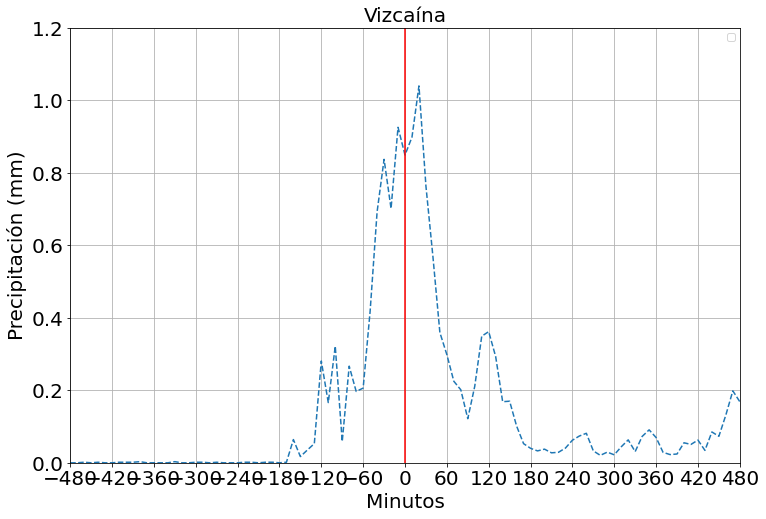

In [29]:
list_percentil = [ 0.05, .1, .20, .25, .50, .75, .80, .90, 0.95]
dfCrossPrecNotNan = dfCrossPrec.dropna().reset_index()
dfPercentilPrec= dfCrossPrecNotNan.groupby("FECHA_POS")['PREC'].quantile(list_percentil).reset_index()
dfAggPrec = dfCrossPrecNotNan.groupby("FECHA_POS").agg({"PREC" : ["mean", "std"]})

dfPercentilPrec = dfPercentilPrec.pivot(index='FECHA_POS', columns='level_1')['PREC'].reset_index()
dfPercentilPrec = dfPercentilPrec.join(dfAggPrec, "FECHA_POS")

dict_names = {'title' : 'Análisis de precipitación', 
              'name2save' : f'analisis_precipitacion_percentil_20h_7h_{NOMBRE_ESTACION}_{int_minutes}m.png', 
              'ylabel' : 'Precipitación (mm)'
              }

plot_percentil_interval_prec(dfPercentilPrec, [.10, .10], 'PREC', dict_names['title'], dict_names['name2save'], dict_names['ylabel'], int_minutes)

# Análisis de Viento

In [30]:
func_dir = lambda df, x, y: np.rad2deg(np.arctan2(df[x], df[y])) if np.arctan2(df[x], df[y]) > 0 else 360 + np.rad2deg(np.arctan2(df[x], df[y]))
func_vel = lambda df, x, y: (df[x]**2 + df[y]**2)**(1/2)

In [31]:
dfEventAnMin['HORA_MINUTO'] = dfEventAnMin['FECHA'].apply(lambda x: x[11:16])
dfEventAnMin


,FECHA_HORA,FECHA_EVENTO,min_t,lon_t,lat_t,FECHA,FECHA_POS,HORA_MINUTO
0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 21:20:00-05:00,-480.0,21:20
1,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 21:30:00-05:00,-470.0,21:30
2,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 21:40:00-05:00,-460.0,21:40
3,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 21:50:00-05:00,-450.0,21:50
4,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 22:00:00-05:00,-440.0,22:00
...,...,...,...,...,...,...,...,...
8531,2017-12-02 05:00:00-05:00,2017-12-02 04:40:00-05:00,207.7,-73.550,6.915,2017-12-02 12:00:00-05:00,440.0,12:00
8532,2017-12-02 05:00:00-05:00,2017-12-02 04:40:00-05:00,207.7,-73.550,6.915,2017-12-02 12:10:00-05:00,450.0,12:10
8533,2017-12-02 05:00:00-05:00,2017-12-02 04:40:00-05:00,207.7,-73.550,6.915,2017-12-02 12:20:00-05:00,460.0,12:20
8534,2017-12-02 05:00:00-05:00,2017-12-02 04:40:00-05:00,207.7,-73.550,6.915,2017-12-02 12:30:00-05:00,470.0,12:30


In [32]:
dfViento['HORA_MINUTO'] = dfViento['FECHA'].apply(lambda x: x[11:16])
dfViento

dfVientoMean = dfViento.groupby('HORA_MINUTO').agg('mean').reset_index(level=0)
dfVientoMean = dfVientoMean.rename(columns={"VELVIENTO":"VELVIENTO_mean"})


In [33]:
dfCrossVientos = pd.merge(dfEventAnMin[['HORA_MINUTO', 'FECHA_POS', 'FECHA']], dfViento[[col for col in dfViento.columns if col != "HORA_MINUTO" ]], on='FECHA', how = 'left')
dfCrossVientos = pd.merge(dfCrossVientos, dfVientoMean[['HORA_MINUTO', 'VELVIENTO_mean']], on='HORA_MINUTO', how = 'left')

### Cálculo de la anomalia
dfCrossVientos['VEL_VIENTO_anomalia'] = dfCrossVientos['VELVIENTO'] - dfCrossVientos['VELVIENTO_mean']

dfCrossVientosGroup = dfCrossVientos.groupby("FECHA_POS").agg({"VEL_VIENTO_anomalia" : ["mean", "std"]}).reset_index()
# dfCrossVientosGroup = dfCrossVientos.groupby("FECHA_POS").agg({"VEL_VIENTO_anomalia" : "mean", "VEL_VIENTO_anomalia" : "std"}).reset_index()
# dfCrossVientosGroup
# dfCrossVientosGroup = dfCrossVientos.groupby("FECHA_POS").agg({"VELVIENTO" : ["mean", "std"]}).reset_index()

dfCrossVientosGroup2 = pd.DataFrame()
dfCrossVientosGroup2['FECHA_POS'] = dfCrossVientosGroup[('FECHA_POS',     '')]
dfCrossVientosGroup2['VEL_VIENTO_STD'] = dfCrossVientosGroup[("VEL_VIENTO_anomalia", "std") ]
dfCrossVientosGroup2['VEL_VIENTO_MEAN'] = dfCrossVientosGroup[("VEL_VIENTO_anomalia", "mean") ]

In [34]:
dfCrossVientos

,HORA_MINUTO,FECHA_POS,FECHA,DIRECVIENTO,VELVIENTO,FECHA_HORA,X_VIENTO,Y_VIENTO,VELVIENTO_mean,VEL_VIENTO_anomalia
0,21:20,-480.0,2011-02-12 21:20:00-05:00,11.0,0.4,2011-02-12 21,-0.076324,-0.392651,0.766103,-0.366103
1,21:30,-470.0,2011-02-12 21:30:00-05:00,12.0,0.4,2011-02-12 21,-0.083165,-0.391259,0.776874,-0.376874
2,21:40,-460.0,2011-02-12 21:40:00-05:00,11.0,1.0,2011-02-12 21,-0.190809,-0.981627,0.774789,0.225211
3,21:50,-450.0,2011-02-12 21:50:00-05:00,9.0,0.7,2011-02-12 21,-0.109504,-0.691382,0.775316,-0.075316
4,22:00,-440.0,2011-02-12 22:00:00-05:00,10.0,0.7,2011-02-12 22,-0.121554,-0.689365,0.791897,-0.091897
...,...,...,...,...,...,...,...,...,...,...
8531,12:00,440.0,2017-12-02 12:00:00-05:00,98.0,1.2,2017-12-02 12,-1.188322,0.167008,1.356140,-0.156140
8532,12:10,450.0,2017-12-02 12:10:00-05:00,93.0,1.5,2017-12-02 12,-1.497944,0.078504,1.336683,0.163317
8533,12:20,460.0,2017-12-02 12:20:00-05:00,99.0,1.3,2017-12-02 12,-1.283995,0.203365,1.373171,-0.073171
8534,12:30,470.0,2017-12-02 12:30:00-05:00,104.0,1.1,2017-12-02 12,-1.067325,0.266114,1.345366,-0.245366


In [35]:
# dfCrossVientos = pd.merge(dfEventAnMin, dfViento, on='FECHA', how = 'left')
# dfCrossVientos = dfCrossVientos.loc[dfCrossVientos['FECHA_POS'] == 240]
# dfCrossVientos["X_VIENTO_STD"] = dfCrossVientos["X_VIENTO"]
# dfCrossVientos["Y_VIENTO_STD"] = dfCrossVientos["Y_VIENTO"]


# dfCrossVientosGroup = dfCrossVientos.groupby("FECHA_POS").agg({"VELVIENTO" : ["mean", "std"]}).reset_index()
# dfCrossVientosGroup = dfCrossVientosGroup.rename(columns = {("VELVIENTO", "mean") : "VEL_VIENTO_mean", ("VELVIENTO", "std") : "VEL_VIENTO_std", ('FECHA_POS',     '') : "FECHA_POS"})
# dfCrossVientosGroup2 = pd.DataFrame()
# dfCrossVientosGroup2['FECHA_POS'] = dfCrossVientosGroup[('FECHA_POS',     '')]
# dfCrossVientosGroup2['VEL_VIENTO_STD'] = dfCrossVientosGroup[("VELVIENTO", "std") ]
# dfCrossVientosGroup2['VEL_VIENTO_MEAN'] = dfCrossVientosGroup[("VELVIENTO", "mean") ]

# dfCrossVientosGroup.rename(columns = {("VELVIENTO", "mean") : "VEL_VIENTO_mean", ("VELVIENTO", "std") : "VEL_VIENTO_std", ('FECHA_POS',     '') : "FECHA_POS"})

# dfCrossVientosGroup['DIR_VIENTO'] = dfCrossVientosGroup.apply(func_dir, x = 'X_VIENTO', y='Y_VIENTO', axis=1)
# dfCrossVientosGroup['DIR_VIENTO'] = (dfCrossVientosGroup['DIR_VIENTO'] + 180.0) % 360
# dfCrossVientosGroup['VEL_VIENTO'] = dfCrossVientosGroup.apply(func_vel, x = 'X_VIENTO', y='Y_VIENTO', axis=1)
# dfCrossVientosGroup['VEL_VIENTO_MEAN'] = dfCrossVientosGroup.apply(func_vel, x = 'X_VIENTO', y='Y_VIENTO', axis=1)
# dfCrossVientosGroup['VEL_VIENTO_STD'] = dfCrossVientosGroup.apply(func_vel, x = 'X_VIENTO_STD', y='Y_VIENTO_STD', axis=1)


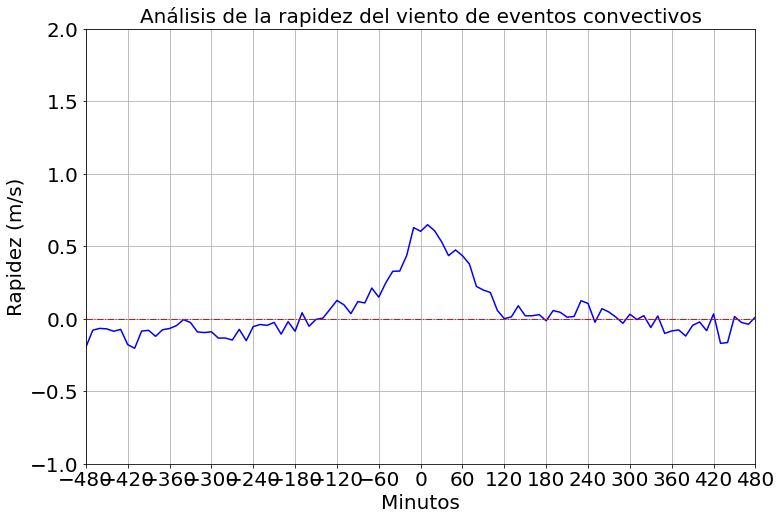

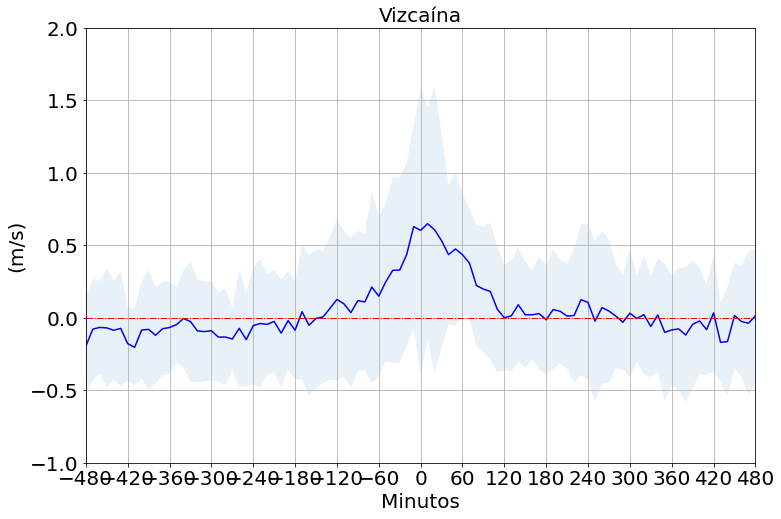

In [36]:
def plot_10m_interval_v2(df, campo, titulo, name_to_save, ylabel_name, int_minutes, ylimit = [], has_std = True):
  plt.figure(figsize = (12,8))

  df['FECHA_POS'] = df['FECHA_POS'].astype(int)
  df['CERO'] = 0
  frequency = 6
  plt.xticks(df['FECHA_POS'][::frequency], fontsize= 20)
  plt.yticks(fontsize= 20)
  if has_std:
    plt.plot(df['FECHA_POS'], df[f"{campo}_MEAN"], color = 'b')
    plt.fill_between(df['FECHA_POS'], df[f"{campo}_MEAN"] + df[f"{campo}_STD"], df[f"{campo}_MEAN"] - df[f"{campo}_STD"], alpha=.1, linestyle = '--', linewidth = 0.5)
  else:
    plt.plot(df['FECHA_POS'], df[f"{campo}_MEAN"], color = 'b')
  plt.plot(df['FECHA_POS'], df['CERO'], color = 'r', linestyle = '-.', linewidth = 1)
  plt.grid()
  # plt.axvline(color = 'r')
  plt.xlim([-int_minutes, int_minutes])
  if ylimit:
    plt.ylim(*ylimit)
  plt.xlabel("Minutos", fontsize= 20)
  plt.ylabel(ylabel_name, fontsize= 20)
  plt.title(titulo, fontsize= 20)

  plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + name_to_save, format='png', bbox_inches = 'tight' )

def plot_dir_viento_interval(df, campo, titulo, name_to_save, ylabel_name, int_minutes, ylimit = [], has_std = True):
  plt.figure(figsize = (12,8))

  df['FECHA_POS'] = df['FECHA_POS'].astype(int)
  df['CERO'] = 0
  frequency = 6
  plt.xticks(df['FECHA_POS'][::frequency], fontsize= 20)
  plt.yticks(fontsize= 20)
  plt.yticks(range(0, 361, 45))
  if has_std:
    plt.plot(df['FECHA_POS'], df[f"{campo}_MEAN"], color = 'b')
    plt.fill_between(df['FECHA_POS'], df[f"{campo}_MEAN"] + df[f"{campo}_STD"], df[f"{campo}_MEAN"] - df[f"{campo}_STD"], alpha=.1, linestyle = '--', linewidth = 0.5)
  else:
    plt.plot(df['FECHA_POS'], df[campo], color = 'b')
  plt.grid()
  plt.axvline(color = 'r')
  plt.xlim([-int_minutes, int_minutes])
  if ylimit:
    plt.ylim(*ylimit)
  plt.xlabel("Minutos", fontsize= 20)
  plt.ylabel(ylabel_name, fontsize= 20)
  plt.title("Vizcaína", fontsize= 25)

  plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + name_to_save, format='png', bbox_inches = 'tight' )

dict_names = {'DIR_VIENTO' : {'title' : 'Análisis de la dirección del viento de eventos convectivos', 'name2save' : f'analisis_dir_viento_20h_7h_{NOMBRE_ESTACION}_{int_minutes}m.png', 'ylabel' : 'Dirección (°)'},
              'VEL_VIENTO' : {'title' : 'Análisis de la rapidez del viento de eventos convectivos', 'name2save' : f'analisis_vel_viento_20h_7h_{NOMBRE_ESTACION}_{int_minutes}m.png', 'ylabel' : 'Rapidez (m/s)'},
              'VEL_VIENTO_2' : {'title' : 'Vizcaína', 'name2save' : f'analisis_vel_viento_std_20h_7h_{NOMBRE_ESTACION}_{int_minutes}m.png', 'ylabel' : '(m/s)'},
             }

# key = 'DIR_VIENTO'
# plot_dir_viento_interval(dfCrossVientosGroup, key, dict_names[key]['title'], dict_names[key]['name2save'], dict_names[key]['ylabel'], int_minutes, ylimit = [0, 360], has_std=False)

key = 'VEL_VIENTO'
plot_10m_interval_v2(dfCrossVientosGroup2, key, dict_names[key]['title'], dict_names[key]['name2save'], dict_names[key]['ylabel'], int_minutes, ylimit=[-1, 2], has_std=False)

key = 'VEL_VIENTO_2'
plot_10m_interval_v2(dfCrossVientosGroup2, 'VEL_VIENTO', dict_names[key]['title'], dict_names[key]['name2save'], dict_names[key]['ylabel'], int_minutes, ylimit=[-1, 2], has_std=True)

## Anáisis de Percentiles

In [37]:
dfCrossVientos

,HORA_MINUTO,FECHA_POS,FECHA,DIRECVIENTO,VELVIENTO,FECHA_HORA,X_VIENTO,Y_VIENTO,VELVIENTO_mean,VEL_VIENTO_anomalia
0,21:20,-480.0,2011-02-12 21:20:00-05:00,11.0,0.4,2011-02-12 21,-0.076324,-0.392651,0.766103,-0.366103
1,21:30,-470.0,2011-02-12 21:30:00-05:00,12.0,0.4,2011-02-12 21,-0.083165,-0.391259,0.776874,-0.376874
2,21:40,-460.0,2011-02-12 21:40:00-05:00,11.0,1.0,2011-02-12 21,-0.190809,-0.981627,0.774789,0.225211
3,21:50,-450.0,2011-02-12 21:50:00-05:00,9.0,0.7,2011-02-12 21,-0.109504,-0.691382,0.775316,-0.075316
4,22:00,-440.0,2011-02-12 22:00:00-05:00,10.0,0.7,2011-02-12 22,-0.121554,-0.689365,0.791897,-0.091897
...,...,...,...,...,...,...,...,...,...,...
8531,12:00,440.0,2017-12-02 12:00:00-05:00,98.0,1.2,2017-12-02 12,-1.188322,0.167008,1.356140,-0.156140
8532,12:10,450.0,2017-12-02 12:10:00-05:00,93.0,1.5,2017-12-02 12,-1.497944,0.078504,1.336683,0.163317
8533,12:20,460.0,2017-12-02 12:20:00-05:00,99.0,1.3,2017-12-02 12,-1.283995,0.203365,1.373171,-0.073171
8534,12:30,470.0,2017-12-02 12:30:00-05:00,104.0,1.1,2017-12-02 12,-1.067325,0.266114,1.345366,-0.245366


In [38]:
def plot_percentil_interval(df, campos, campo_analizar, titulo, name_to_save, ylabel_name, int_minutes, ylimit = []):
  plt.figure(figsize = (12,8))

  df['FECHA_POS'] = df['FECHA_POS'].astype(int)
  df['CERO'] = 0

  frequency = 6
  plt.xticks(df['FECHA_POS'][::frequency], fontsize= 20)
  plt.yticks(fontsize= 20)
  if not .5 in campos:
    campos.append(.5)
  #for campo in campos:
    #plt.plot(df['FECHA_POS'], df[campo], label = f"Percentil {campo}")
  # plt.plot(df['FECHA_POS'], df[0.5], label = f"Percentil {0.5}")
  ## Gráfica del promedio 
  plt.plot(df['FECHA_POS'], df[(campo_analizar, 'mean')], color = 'b')

  ## Gráfica de la desviación standard
  plt.fill_between(df['FECHA_POS'], df[campos[0]] , df[campos[1]], alpha=.1, linestyle = '--', linewidth = 0.5)
  plt.plot(df['FECHA_POS'], df['CERO'], color = 'r', linestyle = '-.', linewidth = 1)

  
  # plt.axvline(color = 'r')
  plt.grid()
  plt.xlim([-int_minutes, int_minutes])
  if ylimit:
    plt.ylim(*ylimit)
  plt.xlabel("Minutos", fontsize= 20)
  plt.ylabel(ylabel_name, fontsize= 20)
  plt.title("Vizcaína", fontsize= 20)
  plt.legend()

  plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + name_to_save, format='png', bbox_inches = 'tight' )


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:9138: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  sort=sort,


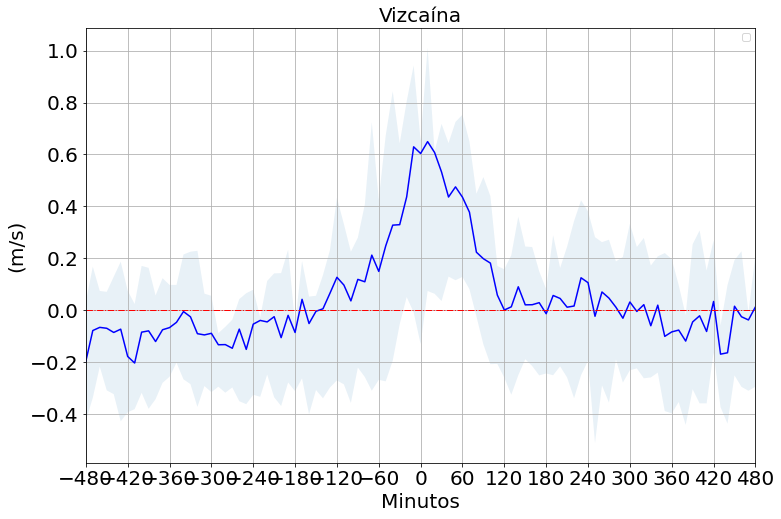

In [39]:
list_percentil = [.10, .20,.25, .50, .75, .80, .90]
dfPercentilViento = dfCrossVientos.groupby("FECHA_POS")['VEL_VIENTO_anomalia'].quantile(list_percentil).reset_index()
dfAggViento = dfCrossVientos.groupby("FECHA_POS").agg({"VEL_VIENTO_anomalia" : ["mean", "std"]})

dfPercentilViento = dfPercentilViento.pivot(index='FECHA_POS', columns='level_1')['VEL_VIENTO_anomalia'].reset_index()
dfPercentilViento = dfPercentilViento.join(dfAggViento, "FECHA_POS")

dict_names = {'title' : 'Vizcaina', 
              'name2save' : f'analisis_rapidez_viento_percentil_20h_7h_{NOMBRE_ESTACION}_{int_minutes}_anomalia_mean.png', 
              'ylabel' : '(m/s)'
              }

plot_percentil_interval(dfPercentilViento, [.25, .75], 'VEL_VIENTO_anomalia', dict_names['title'], dict_names['name2save'], dict_names['ylabel'], int_minutes)

In [40]:
dfPercentilViento

,FECHA_POS,0.1,0.2,0.25,0.5,0.75,0.8,0.9,"(VEL_VIENTO_anomalia, mean)","(VEL_VIENTO_anomalia, std)",CERO
0,-480,-0.532761,-0.462218,-0.426427,-0.328840,0.031784,0.118617,0.252810,-0.196181,0.338179,0
1,-470,-0.471191,-0.367700,-0.336870,-0.124233,0.167802,0.175181,0.267345,-0.078048,0.350093,0
2,-460,-0.433854,-0.289614,-0.217021,-0.107055,0.074309,0.076588,0.225211,-0.065882,0.320049,0
3,-450,-0.414014,-0.344250,-0.308524,-0.116838,0.070902,0.095374,0.150245,-0.069396,0.408218,0
4,-440,-0.497583,-0.349753,-0.322897,-0.118343,0.128952,0.199818,0.387518,-0.085467,0.344523,0
...,...,...,...,...,...,...,...,...,...,...,...
92,440,-0.565526,-0.440681,-0.436454,-0.253787,0.096902,0.146683,0.291056,-0.163634,0.378112,0
93,450,-0.333446,-0.273535,-0.250639,-0.114711,0.192936,0.333690,0.512964,0.015518,0.364691,0
94,460,-0.492742,-0.351007,-0.294934,-0.054573,0.227111,0.299380,0.481360,-0.024986,0.384618,0
95,470,-0.470791,-0.362187,-0.309940,-0.132940,-0.008466,0.303053,0.519314,-0.037281,0.495313,0


# Análisis de viento por hora

In [41]:
dfCrossVientosHora = pd.merge(dfEventAn, df10m, on='FECHA', how = 'left')

dfCrossVientosHora
# dfCrossVientosHoraGroup = dfCrossVientosHora.groupby("FECHA_POS").agg({"X_VIENTO" : "mean", "Y_VIENTO" : "mean"}).reset_index()

dfCrossVientosHora['DIR_VIENTO'] = dfCrossVientosHora.apply(func_dir, x = 'X_VIENTO', y='Y_VIENTO', axis=1)
dfCrossVientosHora['DIR_VIENTO'] = (dfCrossVientosHora['DIR_VIENTO'] + 180.0) % 360
dfCrossVientosHora['VEL_VIENTO'] = dfCrossVientosHora.apply(func_vel, x = 'X_VIENTO', y='Y_VIENTO', axis=1)

dfCrossVientosHora

,index,FECHA_EVENTO,FECHA_MIN,min_t,lon_t,lat_t,FECHA,FECHA_POS,FECHA_HORA,X_VIENTO,Y_VIENTO,HORA,DIRVIENTO,VELVIENTO,DIR_VIENTO,VEL_VIENTO
0,0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 21:00:00-05:00,-8.0,2011-02-12 21,-0.115430,-0.639563,21,190.230764,0.649896,10.230764,0.649896
1,0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 22:00:00-05:00,-7.0,2011-02-12 22,-0.165177,-0.833039,22,191.215285,0.849257,11.215285,0.849257
2,0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 23:00:00-05:00,-6.0,2011-02-12 23,-0.132984,-0.687190,23,190.952379,0.699939,10.952379,0.699939
3,0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-13 00:00:00-05:00,-5.0,2011-02-13 00,-0.090980,-0.593018,00,188.722257,0.599956,8.722257,0.599956
4,0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-13 01:00:00-05:00,-4.0,2011-02-13 01,-0.059542,-0.680530,01,185.000297,0.683130,5.000297,0.683130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1491,87,2017-12-02 05:00:00-05:00,2017-12-02 04:40:00-05:00,207.7,-73.550,6.915,2017-12-02 09:00:00-05:00,4.0,2017-12-02 09,-0.528136,0.649710,09,320.893021,0.837288,140.893021,0.837288
1492,87,2017-12-02 05:00:00-05:00,2017-12-02 04:40:00-05:00,207.7,-73.550,6.915,2017-12-02 10:00:00-05:00,5.0,2017-12-02 10,-0.855572,0.128074,10,278.513588,0.865105,98.513588,0.865105
1493,87,2017-12-02 05:00:00-05:00,2017-12-02 04:40:00-05:00,207.7,-73.550,6.915,2017-12-02 11:00:00-05:00,6.0,2017-12-02 11,-0.454569,0.322393,11,305.345321,0.557288,125.345321,0.557288
1494,87,2017-12-02 05:00:00-05:00,2017-12-02 04:40:00-05:00,207.7,-73.550,6.915,2017-12-02 12:00:00-05:00,7.0,2017-12-02 12,-0.950293,-0.210094,12,257.533364,0.973240,77.533364,0.973240


In [42]:
def plot_windrose(df, title, path_to_save):
  ax = WindroseAxes.from_ax()

  ax.bar(df['DIR_VIENTO'], df['VEL_VIENTO'], normed=True, opening=0.8, bins=np.arange(0.0, 5, 0.5), edgecolor='white', cmap=cm.cool)
  ax.set_legend(loc = 3)
  ax.set_xticklabels(['E', 'NE', 'N', 'NW',  'W', 'SW', 'S', 'SE'])
  plt.title(title)
  plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + path_to_save, format='png', bbox_inches = 'tight' )
  plt.show()

In [43]:
posHoras = set(list(dfCrossVientosHora['FECHA_POS']))
posHoras

{-8.0,
 -7.0,
 -6.0,
 -5.0,
 -4.0,
 -3.0,
 -2.0,
 -1.0,
 0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0}

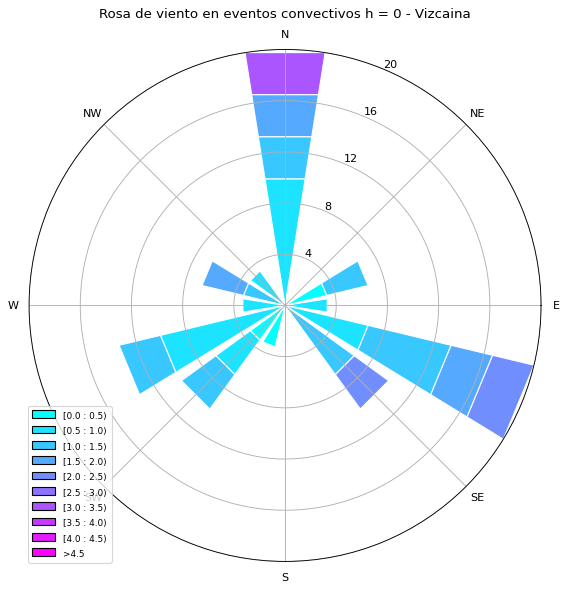

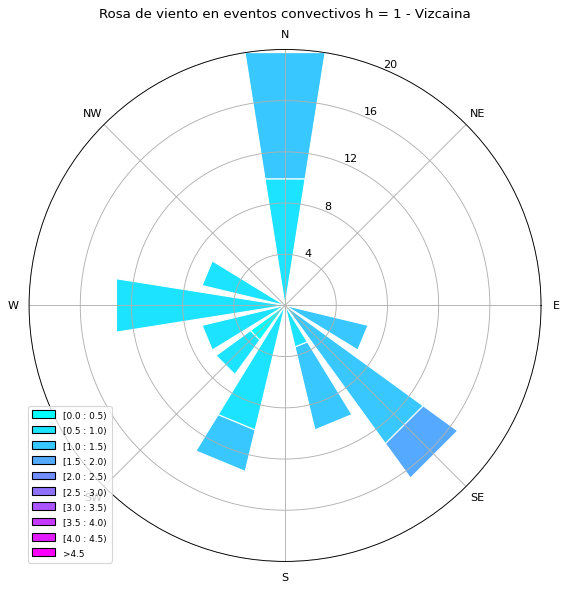

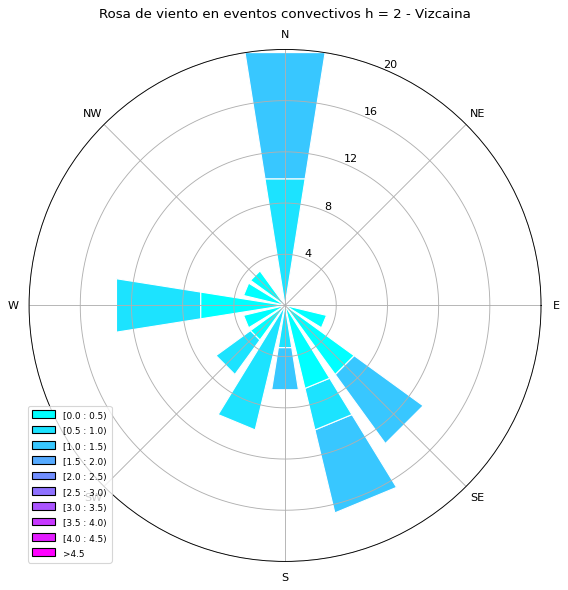

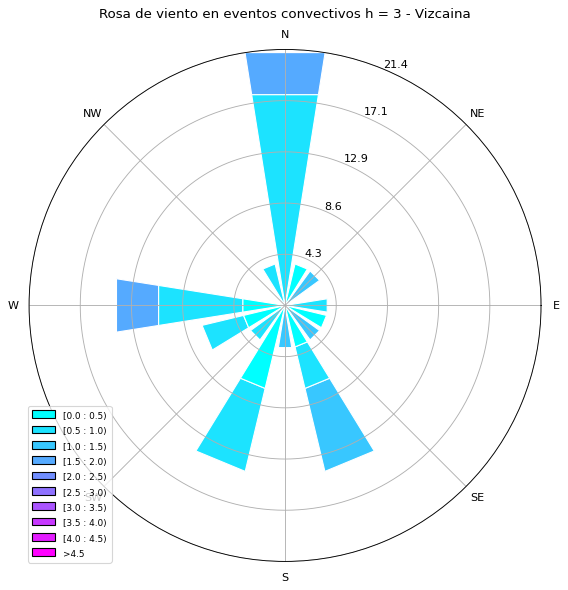

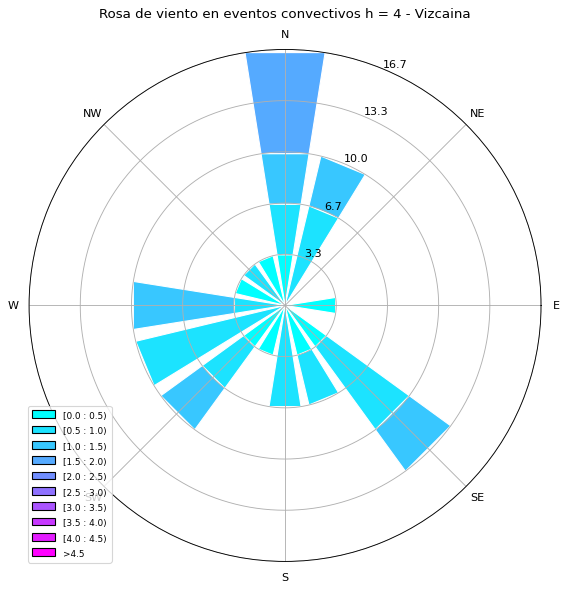

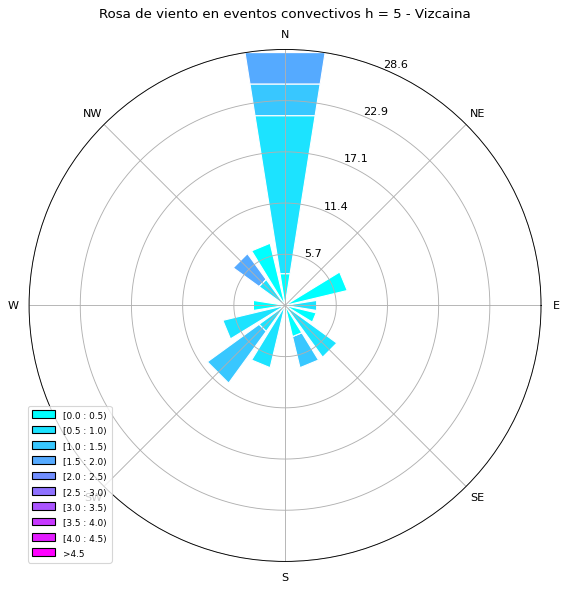

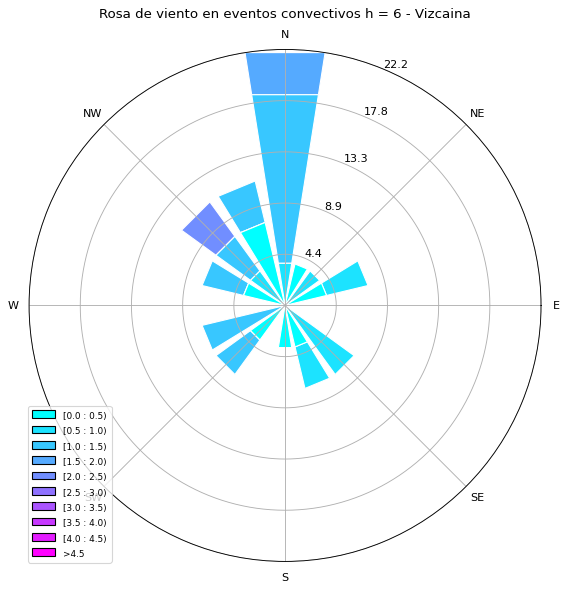

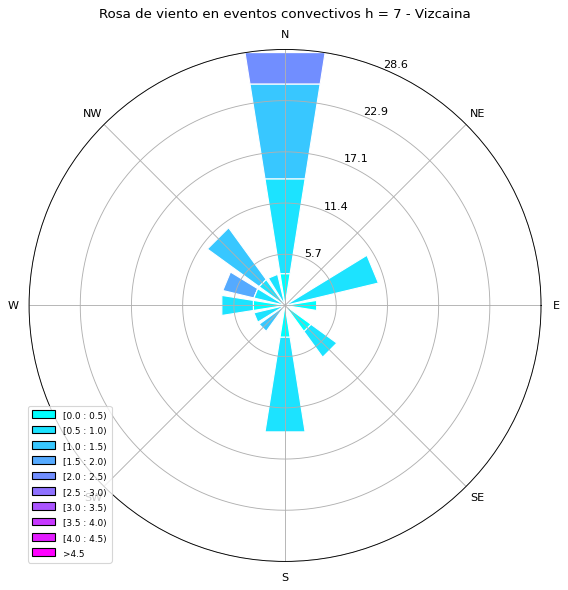

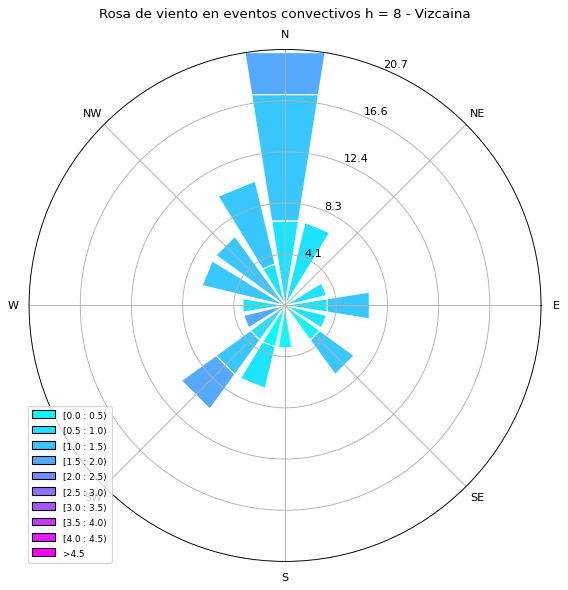

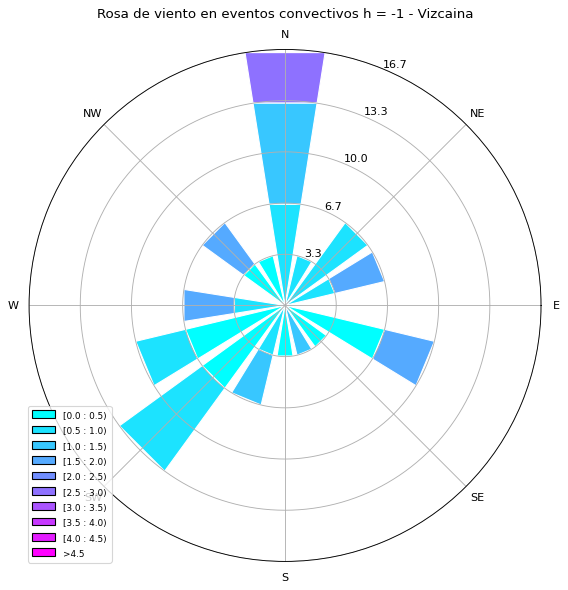

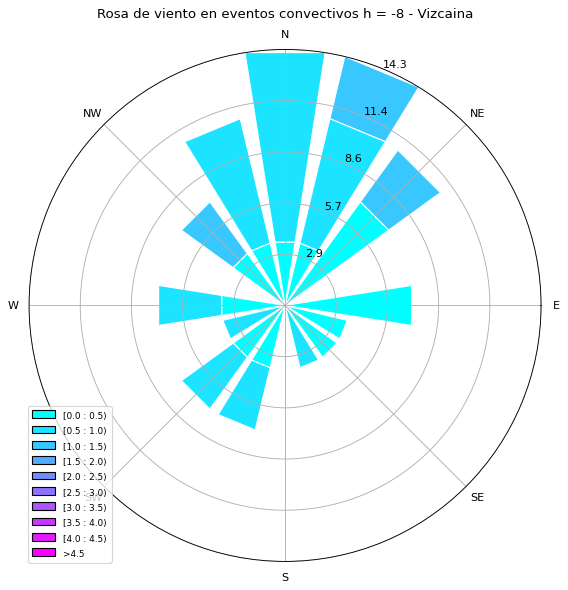

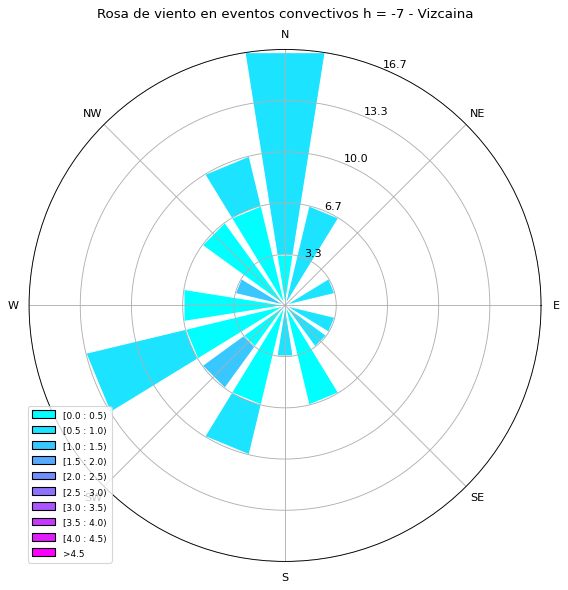

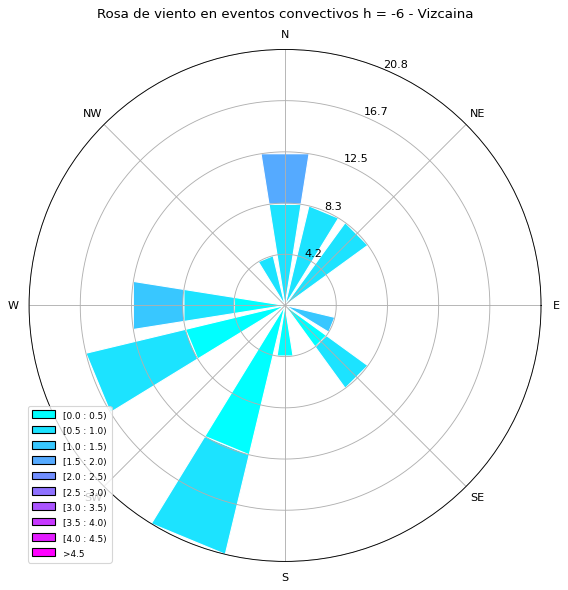

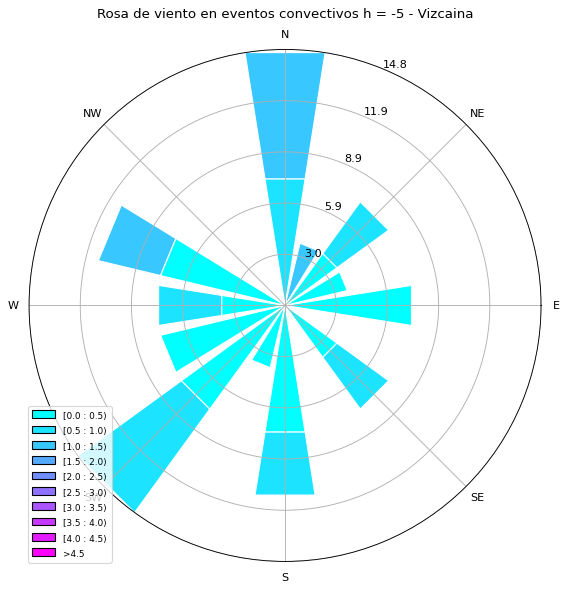

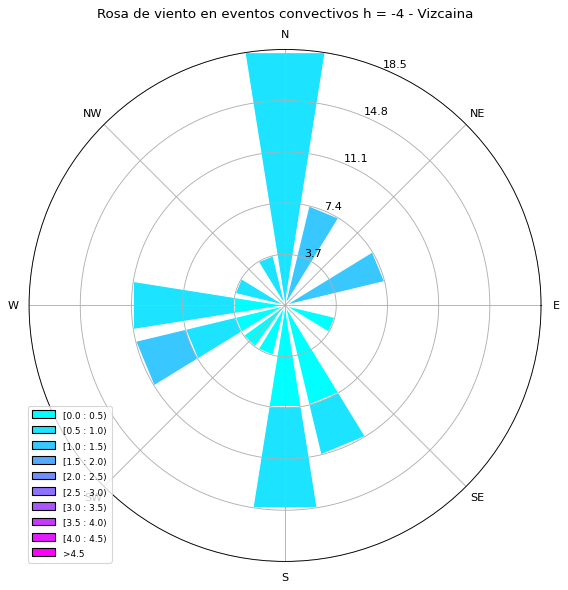

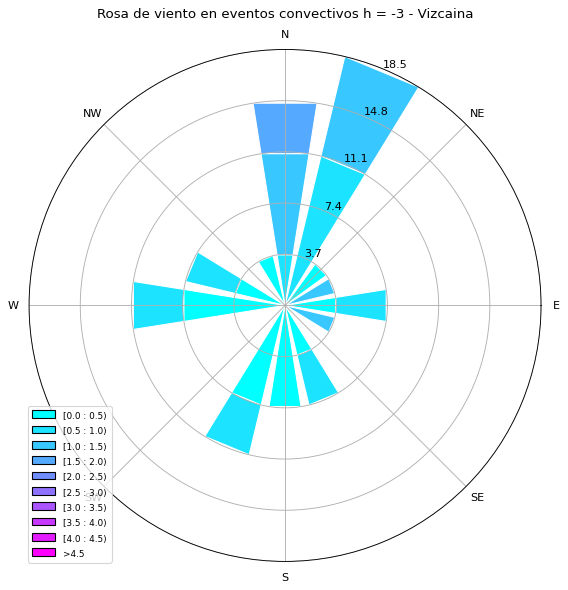

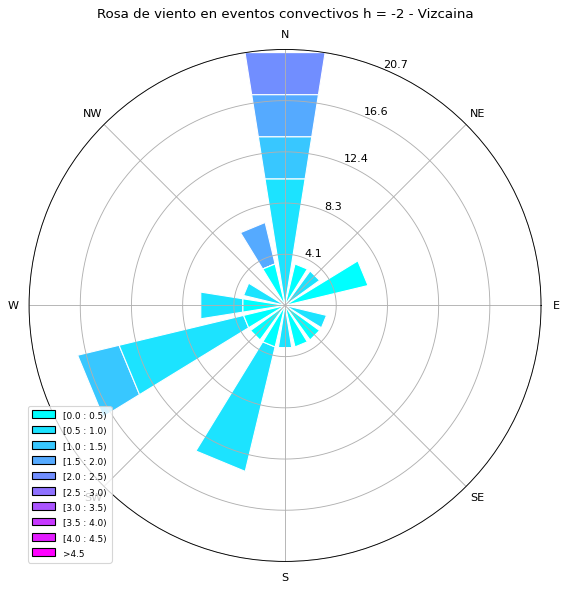

In [44]:
for hora in posHoras:
  dft = dfCrossVientosHora.loc[dfCrossVientosHora['FECHA_POS'] == hora]
  title = f'Rosa de viento en eventos convectivos h = {int(hora)} - {NOMBRE_ESTACION.capitalize()}'
  path_to_save = f'windrose_eventos_convectivos_hora_20h_7h_{int(hora)}_{NOMBRE_ESTACION.lower()}.png'
    
  plot_windrose(dft, title, path_to_save)

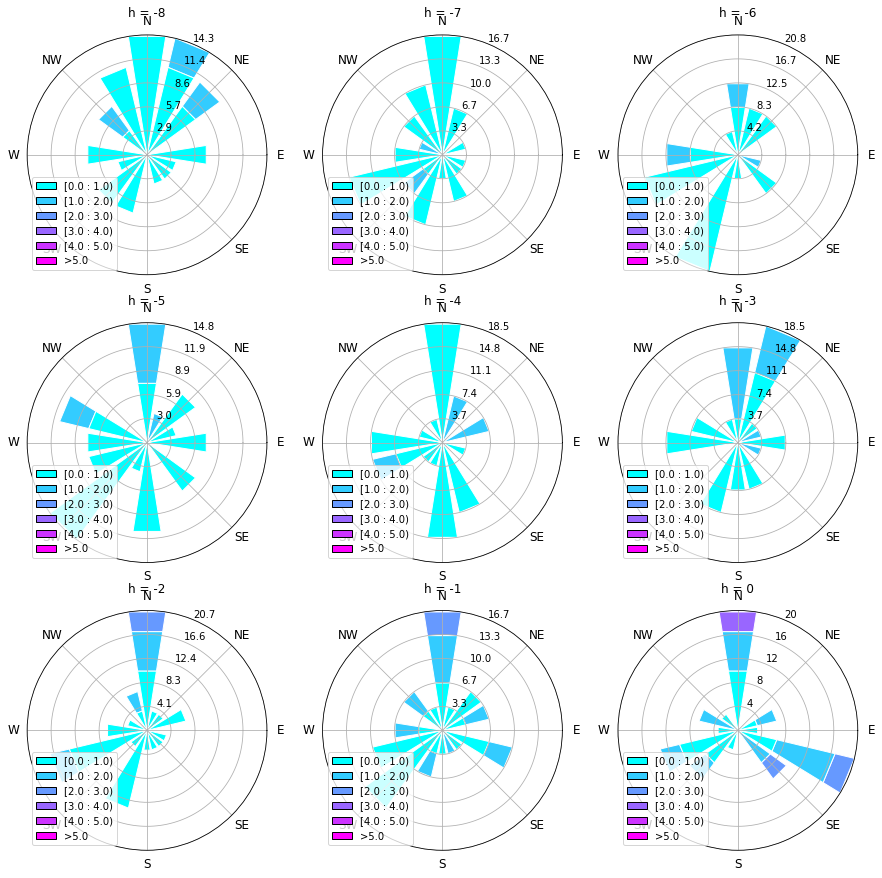

In [45]:
def plot_windrose_2(df, title, ax):
  ax.bar(df['DIR_VIENTO'], df['VEL_VIENTO'], normed=True, opening=0.8, bins=np.arange(0.0, 6), edgecolor='white', cmap=cm.cool)
  ax.legend(loc = 3,fontsize= 10)
  ax.set_xticklabels(['E', 'NE', 'N', 'NW',  'W', 'SW', 'S', 'SE'], fontsize= 12)
  ax.set_title(title)


fig, axs = plt.subplots(3, 3,figsize=(15,15),  subplot_kw=dict(projection="windrose"))
horas = list(posHoras)
horas.sort()

for ax, hora in zip(axs.reshape(9), horas):
  dft = dfCrossVientosHora.loc[dfCrossVientosHora['FECHA_POS'] == hora]
  title = f'h = {int(hora)}'
  plot_windrose_2(dft, title, ax)

path_to_save = f'subplot_vientos_20h_7h_{NOMBRE_ESTACION}.png'
plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + path_to_save, format='png', bbox_inches = 'tight' )
plt.show()

# Gráficos multivariables en único Plot

In [46]:
dfAnomalia

FECHA_POS TEMP_anomalia           HUM_anomalia           PRESION_anomalia  \
                      mean       std         mean       std             mean   
0         -8      0.313457  1.272381     0.303677  5.613169        -1.177072   
1         -7      0.371287  1.254279    -0.211820  5.347254        -1.159257   
2         -6      0.463053  1.339063     0.387660  4.981235        -0.990284   
3         -5      0.536771  1.266859    -0.507361  5.875427        -1.147055   
4         -4      0.438952  1.051251    -0.090501  5.290306        -1.344571   
5         -3      0.575776  0.960205    -0.216755  4.597962        -1.681351   
6         -2      0.642582  0.960855    -0.735208  4.756098        -1.275400   
7         -1      0.544045  1.024049    -0.478233  3.851968        -1.552902   
8          0      0.194884  1.154049    -0.220133  2.631388        -1.459903   
9          1     -0.409998  1.190129     0.218715  2.775148        -1.328218   
10         2     -0.641412  1.260162     1.356291  4.107171        -0.922033   
11         3     -0.724524  1.587410     2.709925  5.941120        -0.582647   
12         4     -0.870439  1.840225     3.326923  7.500779        -0.279395   
13         5     -0.773072  1.828540     3.962711  7.846009        -0.342808   
14         6     -1.007673  1.906563     4.394994  9.036786         0.047439   
15         7     -0.902592  1.727372     4.248794  7.132514         0.121061   
16         8     -1.190189  1.907442     5.669236  7.460127        -0.051943   

             CERO  
         std       
0   1.620191    0  
1   1.994167    0  
2   2.654993    0  
3   2.767963    0  
4   2.450845    0  
5   2.172406    0  
6   3.233782    0  
7   2.513037    0  
8   2.503455    0  
9   2.986905    0  
10  3.413159    0  
11  3.606953    0  
12  3.462804    0  
13  3.216444    0  
14  2.844008    0  
15  2.859367    0  
16  2.630327    0

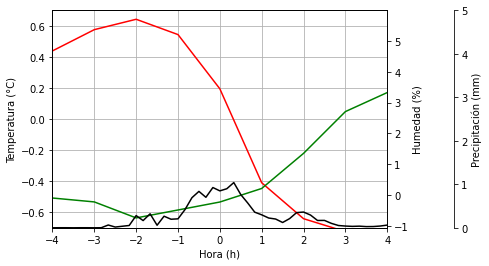

In [47]:
fig, ax = plt.subplots()
ax.plot(dfAnomalia['FECHA_POS'], dfAnomalia[('TEMP_anomalia', 'mean')], c = 'red')
ax.set_ylim(-0.7, 0.7)

ax2=ax.twinx()
ax2.plot(dfAnomalia['FECHA_POS'], dfAnomalia[('HUM_anomalia', 'mean')], c = 'green')

ax3=ax.twinx()
ax3.spines['right'].set_position(('axes', 1.2))
ax3.plot(dfCrossPrecGroup['FECHA_POS']/60.0, dfCrossPrecGroup[('PREC', 'mean')], c = 'black')
ax3.set_ylim(0, 5)

ax.set_xlim(-4, 4)
ax.grid()

ax.set_ylabel("Temperatura (°C)")
ax2.set_ylabel("Humedad (%)")
ax3.set_ylabel("Precipitación (mm)")
ax.set_xlabel("Hora (h)")

path_to_save = f'temp_vs_hum_vs_prec_anomalias_{NOMBRE_ESTACION}.png'
plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + path_to_save, format='png', bbox_inches = 'tight' )

KeyError: ignored

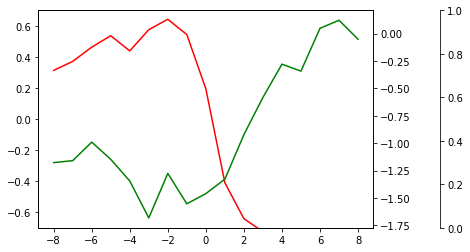

In [48]:
fig, ax = plt.subplots()
ax.plot(dfAnomalia['FECHA_POS'], dfAnomalia[('TEMP_anomalia', 'mean')], c = 'red')
ax.set_ylim(-0.7, 0.7)

ax2=ax.twinx()
ax2.plot(dfAnomalia['FECHA_POS'], dfAnomalia[('PRESION_anomalia', 'mean')], c = 'green')

ax3=ax.twinx()
ax3.spines['right'].set_position(('axes', 1.2))
ax3.plot(dfCrossVientosGroup['FECHA_POS']/60.0, dfCrossVientosGroup['VELVIENTO'], c = 'black')
# ax3.set_ylim(0, 0.5)

ax.set_xlim(-4, 4)
ax.grid()

ax.set_ylabel("Temperatura (°C)")
ax2.set_ylabel("Presión (hPa)")
ax3.set_ylabel("Velocidad del viento (m/s)")
ax.set_xlabel("Hora (h)")

path_to_save = f'temp_vs_pres_vs_velviento_anomalias_{NOMBRE_ESTACION}.png'
plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + path_to_save, format='png', bbox_inches = 'tight' )